<h1>PAD Lab Experiment 9</h1>

<h2>Roshan Srivastava <br> J047<br>MBA Tech. EXTC SEM 7</h2>

<h3>Aim: Auto-Encoder for Anomaly Dectection</h3>

<h1>Part 1:</h1>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv("http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv",header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [4]:
features = data.drop(140,axis=1)
label = data.iloc[:,140]

In [5]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(features,label,test_size=0.2,stratify=label,random_state=240500)

In [6]:
train_index = y_train[y_train==1].index
train_data = x_train.loc[train_index]

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
x_train_scale = scaler.fit_transform(train_data)
x_test_scale = scaler.transform(x_test)

In [8]:
from keras.models import Sequential
from keras.layers import Dense,Dropout
import keras

In [9]:
input_layer = keras.Input(shape=(x_train_scale.shape[1]))
hidden = Dense(64,activation='relu')(input_layer)
hidden = Dropout(0.1)(hidden)
hidden = Dense(32,activation='relu')(hidden)
hidden = Dropout(0.1)(hidden)
hidden = Dense(16,activation='relu')(hidden)
hidden = Dropout(0.1)(hidden)
encoder= Dense(8,activation='relu')(hidden)
decoder = Dense(x_train_scale.shape[1],activation='sigmoid')(hidden)

In [10]:
auto_model = keras.Model(input_layer,decoder)
auto_model.compile(loss='msle',metrics=['mse'],optimizer='adam')
history = auto_model.fit(x_train_scale,x_train_scale,epochs=20,batch_size=52,validation_data=(x_test_scale,x_test_scale))

Epoch 1/20
45/45 [==============================] - 1s 9ms/step - loss: 0.0097 - mse: 0.0222 - val_loss: 0.0123 - val_mse: 0.0282
Epoch 2/20
45/45 [==============================] - 0s 3ms/step - loss: 0.0058 - mse: 0.0131 - val_loss: 0.0100 - val_mse: 0.0232
Epoch 3/20
45/45 [==============================] - 0s 3ms/step - loss: 0.0046 - mse: 0.0104 - val_loss: 0.0095 - val_mse: 0.0220
Epoch 4/20
45/45 [==============================] - 0s 3ms/step - loss: 0.0043 - mse: 0.0097 - val_loss: 0.0092 - val_mse: 0.0213
Epoch 5/20
45/45 [==============================] - 0s 3ms/step - loss: 0.0039 - mse: 0.0087 - val_loss: 0.0086 - val_mse: 0.0198
Epoch 6/20
45/45 [==============================] - 0s 3ms/step - loss: 0.0033 - mse: 0.0074 - val_loss: 0.0081 - val_mse: 0.0186
Epoch 7/20
45/45 [==============================] - 0s 3ms/step - loss: 0.0029 - mse: 0.0066 - val_loss: 0.0078 - val_mse: 0.0179
Epoch 8/20
45/45 [==============================] - 0s 3ms/step - loss: 0.0027 - mse: 0.00

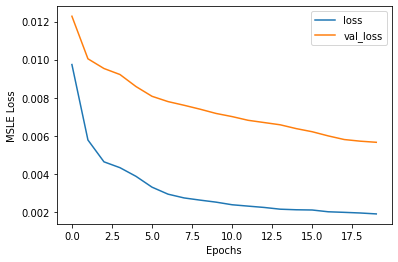

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epochs")
plt.ylabel("MSLE Loss")
plt.legend(['loss','val_loss'])

In [12]:
def threshold(model,x_train_scaled):
    reconstr_output = model.predict(x_train_scaled)
    reconstr_errors = keras.losses.msle(reconstr_output,x_train_scale)
    threshold_error = np.mean(reconstr_errors.numpy()) / +np.std(reconstr_errors)
    return threshold_error

def threshold_perc(model,x_train_scaled):
    reconstr_output = model.predict(x_train_scaled)
    reconstr_errors = keras.losses.msle(reconstr_output,x_train_scaled)
    threshold_error = np.percentile(reconstr_errors,95)
    return threshold_error
  
def predictions(model,x_test_scaled,threshold):
    pred = model.predict(x_test_scale)
    errors = keras.losses.msle(pred,x_test_scaled)
    anomaly = pd.Series(errors)>threshold
    final_pred = anomaly.map(lambda x:0 if x==True else 1)
    return final_pred

In [13]:
t = threshold(auto_model,x_train_scale)
t_perc = threshold_perc(auto_model,x_train_scale)
pred = predictions(auto_model,x_test_scale,t_perc)

In [14]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,pred)

0.963

<h1>Conclusion</h1>
<ol>
<li>Autoencoder is used to identify outliers in the given dataset.</li> 
<li>Autoencoder model uses 3 hidden layers in each of encoder and decoder.</li> 
<li>Samples having MSE which is more than threshold are identified as outliers.</li> 
<li>The model shows 80.3% accuracy for predicting the outliers in test samples.</li>
</ol>